# Financial Fraud Detection with XGBoost on AWS SageMaker

## Introduction

This notebook demonstrates a complete machine learning workflow for detecting fraudulent financial transactions. We will use a balanced dataset of financial transactions and leverage the power of Amazon SageMaker to train, tune, and deploy an XGBoost model. The primary goal is to build a robust model that can accurately identify fraudulent transactions, which is a critical task for any financial institution.

The notebook covers the following key stages:
*   **Setup and Data Preparation:** Installing necessary libraries, loading the data from an S3 bucket, and splitting it into training, validation, and testing sets.
*   **Initial Model Training:** Training an initial XGBoost model with a baseline set of hyperparameters.
*   **Model Deployment and Evaluation:** Deploying the initial model to a SageMaker endpoint and evaluating its performance using various metrics.
*   **Hyperparameter Tuning:** Using SageMaker's automatic hyperparameter tuning to find the optimal set of hyperparameters for our XGBoost model.
*   **Tuned Model Deployment and Evaluation:** Deploying the best model from the tuning job and evaluating its improved performance.
*   **Model Registration:** Registering the final, tuned model in the SageMaker Model Registry for versioning and production deployment.
*   **Cleanup:** Deleting the SageMaker endpoints to avoid incurring unnecessary costs.

---

## Table of Contents

1.  [Setup and Dependencies](#setup)
2.  [Data Loading and Preparation](#data-loading)
    1.  [Loading the Dataset](#load-data)
    2.  [Data Splitting](#data-split)
    3.  [Uploading Data to S3](#upload-s3)
3.  [Model Training (Before Hyperparameter Tuning)](#initial-training)
    1.  [Retrieve XGBoost Image](#xgboost-image)
    2.  [Define Estimator](#define-estimator)
    3.  [Set Hyperparameters](#set-hyperparameters)
    4.  [Train the Model](#train-initial-model)
4.  [Deploy and Evaluate the Initial Model](#deploy-initial)
    1.  [Deploy the Model](#deploy-model)
    2.  [Evaluate the Model](#evaluate-initial)
5.  [Hyperparameter Tuning](#hyperparameter-tuning)
    1.  [Define Hyperparameter Ranges](#define-ranges)
    2.  [Configure the Tuner](#configure-tuner)
    3.  [Start the Tuning Job](#start-tuning)
    4.  [Analyze Tuning Results](#analyze-tuning)
6.  [Deploy and Evaluate the Tuned Model](#deploy-tuned)
    1.  [Deploy the Best Model](#deploy-best)
    2.  [Evaluate the Tuned Model](#evaluate-tuned)
7.  [Register the Model in SageMaker Model Registry](#register-model)
    1.  [Create Model Package Group](#create-group)
    2.  [Define Model Metrics](#define-metrics)
    3.  [Register the Model](#register)
    4.  [Approve the Model](#approve-model)
8.  [Cleanup](#cleanup)

---

## 1. Setup and Dependencies

### 1.1. Install Required Libraries
First, we install the necessary Python libraries that are not pre-installed in the SageMaker environment. `s3fs` is needed for interacting with S3, and `matplotlib` and `seaborn` are for data visualization.

In [ ]:
!pip install matplotlib seaborn

In [ ]:
!pip install s3fs==2025.7.0

In [ ]:
!pip install --upgrade --no-cache-dir numexpr

In [ ]:
import os
os._exit(00)

### 1.2. Import Libraries
Next, we import all the required libraries for our project. This includes `pandas` for data manipulation, `sagemaker` and `boto3` for interacting with AWS services, and `sklearn` for machine learning utilities.

In [1]:
# ─────────────────────────────────────────────
# Standard Library Imports
# ─────────────────────────────────────────────
import io
import os
from datetime import datetime
import time
import json
from IPython.display import FileLink, FileLinks

# ─────────────────────────────────────────────
# Third-Party Libraries
# ─────────────────────────────────────────────
import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import s3fs
from IPython.display import FileLink, FileLinks
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split

# ─────────────────────────────────────────────
# SageMaker Core Libraries
# ─────────────────────────────────────────────
import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.predictor import Predictor
from sagemaker.s3 import S3Uploader
from sagemaker.serializers import CSVSerializer
from sagemaker.session import TrainingInput
from sagemaker.model_metrics import ModelMetrics, MetricsSource

# ─────────────────────────────────────────────
# SageMaker Tuner (Hyperparameter Optimization)
# ─────────────────────────────────────────────
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


---

## 2. Data Loading and Preparation
We load our balanced and preprocessed dataset from the specified S3 URI into a pandas DataFrame. We then display the first few rows to inspect the data.


In [4]:
s3_uri = 's3://transformed-financial-transaction-fraud-detection-using-aws/balanced preprocessed financial-transaction-fraud-detection-using-aws_05Aug2025_1754391923024/balanced preprocessed financial-transaction-fraud-detection-using-aws_05Aug2025_1754391923024_part00000.csv'

df = pd.read_csv(s3_uri)
df.head()

,transaction_month,transaction_day_of_week,transaction_hour,merchant_mapped,category_mapped,amt_normalized column,gender_mapped,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
0,7,5,4,23.0,14.0,0.026282,1,11978,40.8295,-72.6473,3255,1375245092,40.577633,-72.454276,0
1,7,6,0,23.0,14.0,0.004987,1,53910,43.8967,-89.8219,3508,1374710635,43.440998,-89.391536,1
2,8,7,0,23.0,13.0,0.004887,1,31605,30.9460,-83.2474,94325,1377823664,30.473085,-82.955299,0
3,8,7,21,23.0,1.0,0.022345,1,98027,47.4974,-122.0107,50489,1377293505,47.769791,-122.795592,0
4,7,5,4,23.0,8.0,0.009894,1,16048,41.0472,-79.8089,139,1374639105,41.291433,-79.701780,0


### 2.2. Inspecting the Target Variable
We check the distribution of our target variable, `is_fraud`, to confirm that the dataset is balanced.

In [5]:
df["is_fraud"].value_counts()

is_fraud
0    2145
1    2145
Name: count, dtype: int64

### 2.3. Reordering Columns
For training with XGBoost in SageMaker, the target variable must be the first column in the dataset. We reorder the columns to meet this requirement.


In [6]:
df = df[['is_fraud'] + [col for col in df.columns if col != 'is_fraud']]
df.head()

,is_fraud,transaction_month,transaction_day_of_week,transaction_hour,merchant_mapped,category_mapped,amt_normalized column,gender_mapped,zip,lat,long,city_pop,unix_time,merch_lat,merch_long
0,0,7,5,4,23.0,14.0,0.026282,1,11978,40.8295,-72.6473,3255,1375245092,40.577633,-72.454276
1,1,7,6,0,23.0,14.0,0.004987,1,53910,43.8967,-89.8219,3508,1374710635,43.440998,-89.391536
2,0,8,7,0,23.0,13.0,0.004887,1,31605,30.9460,-83.2474,94325,1377823664,30.473085,-82.955299
3,0,8,7,21,23.0,1.0,0.022345,1,98027,47.4974,-122.0107,50489,1377293505,47.769791,-122.795592
4,0,7,5,4,23.0,8.0,0.009894,1,16048,41.0472,-79.8089,139,1374639105,41.291433,-79.701780


### 2.4. Data Splitting
We split the dataset into three parts: a training set (80%), a validation set (10%), and a test set (10%). The `stratify` parameter ensures that the proportion of the target variable is the same across all splits.

In [7]:
train, test_and_validate = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["is_fraud"]
)

test, validate = train_test_split(
    test_and_validate,
    test_size=0.5,
    random_state=42,
    stratify=test_and_validate["is_fraud"]
)

### 2.5. Verifying Split Shapes
We print the shapes of the resulting datasets to ensure the split was successful.

In [8]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Validate shape:", validate.shape)

Train shape: (3432, 15)
Test shape: (429, 15)
Validate shape: (429, 15)


### 2.6. Setting up S3 Paths and Uploading Data
We define the S3 bucket and prefix for our project and specify the filenames for our train, test, and validation datasets. Then, we upload these files to their respective S3 locations.

In [19]:
region = sagemaker.Session().boto_region_name
session = sagemaker.Session()
role = sagemaker.get_execution_role()
s3_resource = boto3.Session().resource('s3')

bucket = 'test-bucket-second-rerun'
prefix = 'fraud-detection'

train_file = 'fraud_train.csv'
test_file = 'fraud_test.csv'
validate_file = 'fraud_validate.csv'

train_path = f's3://{bucket}/{prefix}/train/{train_file}'
test_path = f's3://{bucket}/{prefix}/test/{test_file}'
validate_path = f's3://{bucket}/{prefix}/validate/{validate_file}'

s3_output_location = "s3://{}/{}/{}".format(bucket, prefix, "model")

print(f"Region: {region}")
print(f"Execution Role: {role}")
print(f"S3 Output Location: {s3_output_location}")

Region: us-east-1
Execution Role: arn:aws:iam::527054996464:role/LabRole
S3 Output Location: s3://test-bucket-second-rerun/fraud-detection/model


*The following lines are commented out as they are for the initial upload.*

In [10]:
# train.to_csv(train_path, index=False, header=False)
# test.to_csv(test_path, index=False, header=False)
# validate.to_csv(validate_path, index=False, header=False)

# print("All files successfully uploaded to S3!")

All files successfully uploaded to S3!


Verify that the files are in S3

In [11]:
!aws s3 ls {bucket}/{prefix}/ --recursive

2025-08-07 10:12:08      43512 fraud-detection/test/fraud_test.csv
2025-08-07 10:12:08     347746 fraud-detection/train/fraud_train.csv
2025-08-07 10:12:08      43443 fraud-detection/validate/fraud_validate.csv


---

## 3. Model Training (Before Hyperparameter Tuning)

### 3.1. Retrieve the XGBoost Docker Image
We retrieve the URI for the pre-built XGBoost Docker image from SageMaker's image repository.

In [12]:
model_img = sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")
print(model_img)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1


### 3.2. Define the SageMaker Estimator
We create a SageMaker `Estimator` object for our XGBoost model. This defines the training job's configuration, including the instance type, output path, and any debugging or profiling rules.

In [20]:
base_job_name = "fraud-detection-second-rerun"
job_name = base_job_name + datetime.today().strftime("%Y-%m-%d-%H-%M-%S")

In [25]:
xgb_model = sagemaker.estimator.Estimator(
    image_uri=model_img,
    role=role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(),
    rules=[
        Rule.sagemaker(rule_configs.create_xgboost_report()),
        ProfilerRule.sagemaker(rule_configs.ProfilerReport())
    ]
)

### 3.3. Set Initial Hyperparameters
We set a baseline of hyperparameters for the XGBoost model. These values will be used for our initial training run.

In [26]:
xgb_model.set_hyperparameters(
    max_depth = 5,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.7,
    objective = "binary:logistic",
    num_round = 50
)

### 3.4. Configure Data Inputs and Train the Model
We use the `TrainingInput` class to specify the S3 locations of our training and validation data. Then, we start the training job by calling the `fit()` method.

In [27]:
train_ip = TrainingInput("s3://{}/{}/{}".format(bucket, prefix, "test/fraud_test.csv"), content_type="csv")
valid_ip = TrainingInput("s3://{}/{}/{}".format(bucket, prefix, "validate/fraud_validate.csv"), content_type="csv")

In [28]:
xgb_model.fit({"train": train_ip, "validation": valid_ip}, wait=True, job_name=job_name)

INFO:sagemaker:Creating training-job with name: fraud-detection-second-rerun2025-08-07-10-18-07


2025-08-07 10:18:59 Starting - Starting the training job...
2025-08-07 10:19:27 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
ProfilerReport: InProgress
...
2025-08-07 10:20:00 Downloading - Downloading input data...
2025-08-07 10:20:20 Downloading - Downloading the training image...
2025-08-07 10:21:00 Training - Training image download completed. Training in progress..[2025-08-07 10:21:04.482 ip-10-2-228-209.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determ

*We can see that model already started converging to the minima after 37 rounds*

### 3.5. Analyze SageMaker Debugger and Profiler Reports
After training, we can download and view the SageMaker Debugger and Profiler reports to get insights into the training process and resource utilization.

In [35]:
rule_output_path = xgb_model.output_path + "/" + xgb_model.latest_training_job.job_name + "/rule-output"
! aws s3 ls {rule_output_path} --recursive

2025-08-07 10:21:13        312 fraud-detection/model/fraud-detection-second-rerun2025-08-07-10-18-07/rule-output/CreateXgboostReport/xgboost-reports/ConfusionMatrix.json
2025-08-07 10:21:13        732 fraud-detection/model/fraud-detection-second-rerun2025-08-07-10-18-07/rule-output/CreateXgboostReport/xgboost-reports/EvaluationMetrics.json
2025-08-07 10:21:13       1826 fraud-detection/model/fraud-detection-second-rerun2025-08-07-10-18-07/rule-output/CreateXgboostReport/xgboost-reports/FeatureImportance.json
2025-08-07 10:21:13        508 fraud-detection/model/fraud-detection-second-rerun2025-08-07-10-18-07/rule-output/CreateXgboostReport/xgboost-reports/IterativeClassAccuracy.json
2025-08-07 10:21:13        176 fraud-detection/model/fraud-detection-second-rerun2025-08-07-10-18-07/rule-output/CreateXgboostReport/xgboost-reports/LabelsDistribution.json
2025-08-07 10:21:13       1822 fraud-detection/model/fraud-detection-second-rerun2025-08-07-10-18-07/rule-output/CreateXgboostReport/xgb

In [36]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://test-bucket-second-rerun/fraud-detection/model/fraud-detection-second-rerun2025-08-07-10-18-07/rule-output/CreateXgboostReport/xgboost-reports/FeatureImportance.json to CreateXgboostReport/xgboost-reports/FeatureImportance.json
download: s3://test-bucket-second-rerun/fraud-detection/model/fraud-detection-second-rerun2025-08-07-10-18-07/rule-output/CreateXgboostReport/xgboost-reports/ConfusionMatrix.json to CreateXgboostReport/xgboost-reports/ConfusionMatrix.json
download: s3://test-bucket-second-rerun/fraud-detection/model/fraud-detection-second-rerun2025-08-07-10-18-07/rule-output/CreateXgboostReport/xgboost-reports/LossData.json to CreateXgboostReport/xgboost-reports/LossData.json
download: s3://test-bucket-second-rerun/fraud-detection/model/fraud-detection-second-rerun2025-08-07-10-18-07/rule-output/CreateXgboostReport/xgboost-reports/IterativeClassAccuracy.json to CreateXgboostReport/xgboost-reports/IterativeClassAccuracy.json
download: s3://test-bucket-second-rerun/

In [39]:
display("Click link below to view the XGBoost Training report", FileLink("CreateXgboostReport/xgboost_report.html"))

'Click link below to view the XGBoost Training report'

/home/ec2-user/SageMaker/CreateXgboostReport/xgboost_report.html

In [40]:
profiler_report_name = [rule["RuleConfigurationName"] 
                        for rule in xgb_model.latest_training_job.rule_job_summary() 
                        if "Profiler" in rule["RuleConfigurationName"]][0]
display("Click link below to view the profiler report", FileLink(profiler_report_name+"/profiler-output/profiler-report.html"))

'Click link below to view the profiler report'

/home/ec2-user/SageMaker/ProfilerReport/profiler-output/profiler-report.html

---

## 4. Deploy and Evaluate the Initial Model

### 4.1. Deploy the Model to a SageMaker Endpoint
We deploy the trained model to a real-time endpoint, which can be used for making predictions. We specify the instance type and count for the endpoint.

In [41]:
xgb_predictor = xgb_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    serializer=CSVSerializer()
)

print(f"Endpoint name: {xgb_predictor.endpoint_name}")

INFO:sagemaker:Creating model with name: fraud-detection-second-rerun-2025-08-07-10-25-07-149
INFO:sagemaker:Creating endpoint-config with name fraud-detection-second-rerun-2025-08-07-10-25-07-149
INFO:sagemaker:Creating endpoint with name fraud-detection-second-rerun-2025-08-07-10-25-07-149


------!Endpoint name: fraud-detection-second-rerun-2025-08-07-10-25-07-149


### 4.2. Evaluate the Deployed Model
We use the test set to evaluate the performance of our deployed model. We make predictions on the test data and then calculate various classification metrics.

#### 4.2.1. Prepare Test Data

In [42]:
X_test = test.iloc[:, 1:]
y_true = test.iloc[:, 0]

Convert to numpy array for prediction

In [43]:
if isinstance(X_test, pd.DataFrame):
    X_test_np = X_test.to_numpy()
else:
    X_test_np = X_test

#### 4.2.2. Make Predictions

In [44]:
raw_predictions = xgb_predictor.predict(X_test_np)
predictions_str = raw_predictions.decode('utf-8')
predicted_probabilities = np.fromstring(predictions_str, sep=',')

In [45]:
predicted_labels = (predicted_probabilities > 0.5).astype(int)

#### 4.2.3. Calculate and Display Metrics

In [46]:
accuracy = accuracy_score(y_true, predicted_labels)
precision = precision_score(y_true, predicted_labels)
recall = recall_score(y_true, predicted_labels)
f1 = f1_score(y_true, predicted_labels)
conf_matrix = confusion_matrix(y_true, predicted_labels)

In [47]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9371
Precision: 0.9476
Recall: 0.9256
F1-Score: 0.9365


Confusion Matrix:


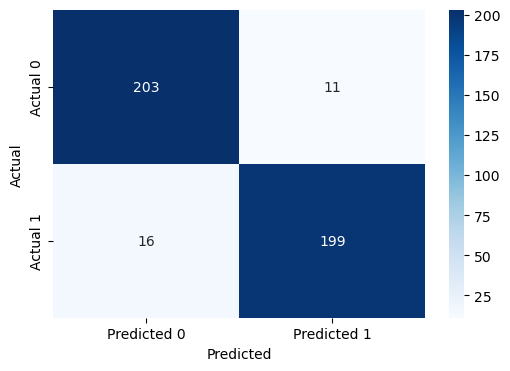

In [48]:
print("Confusion Matrix:")
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

---

## 5. Hyperparameter Tuning
To improve our model's performance, we use SageMaker's automatic hyperparameter tuning capabilities.

### 5.1. Define Hyperparameter Ranges
We specify the ranges for the hyperparameters we want to tune.

In [49]:
hyperparameter_ranges = {
    "max_depth": IntegerParameter(4, 7),
    "eta": ContinuousParameter(0.1, 0.3),
    "gamma": ContinuousParameter(3.0, 5.0),
    "min_child_weight": IntegerParameter(5, 8),
    "subsample": ContinuousParameter(0.6, 0.8),
}

### 5.2. Configure the Hyperparameter Tuner
We create a `HyperparameterTuner` object, specifying the base estimator, the objective metric to optimize, the hyperparameter ranges, and the number of tuning jobs to run.

In [50]:
tuner = HyperparameterTuner(
    estimator=xgb_model,
    objective_metric_name="validation:error",
    hyperparameter_ranges=hyperparameter_ranges,
    objective_type="Minimize",
    max_jobs=20,
    max_parallel_jobs=5,
)

### 5.3. Start the Tuning Job
We start the hyperparameter tuning job by calling the `fit()` method on the tuner object.

In [51]:
tuner.fit({"train": train_ip, "validation": valid_ip})

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-250807-1029


............................................................................!


### 5.4. Analyze Tuning Results
After the tuning job is complete, we can retrieve the best-performing model and its hyperparameters.

In [52]:
best_tuner = tuner.best_estimator()
print("Best performing model's hyperparameters:")
best_tuner.hyperparameters()


2025-08-07 10:35:43 Starting - Found matching resource for reuse
2025-08-07 10:35:43 Downloading - Downloading the training image
2025-08-07 10:35:43 Training - Training image download completed. Training in progress.
2025-08-07 10:35:43 Uploading - Uploading generated training model
2025-08-07 10:35:43 Completed - Resource retained for reuse
Best performing model's hyperparameters:


{'_tuning_objective_metric': 'validation:error',
 'eta': '0.20024249265390176',
 'gamma': '4.451655992726725',
 'max_depth': '7',
 'min_child_weight': '5',
 'num_round': '50',
 'objective': 'binary:logistic',
 'subsample': '0.7902051456709067'}

In [53]:
print("Best training job name:")
print(tuner.best_training_job())

Best training job name:
sagemaker-xgboost-250807-1029-017-c1550cb4


In [54]:
print("Best model artifact location:")
print(best_tuner.model_data)

Best model artifact location:
s3://test-bucket-second-rerun/fraud-detection/model/sagemaker-xgboost-250807-1029-017-c1550cb4/output/model.tar.gz


---

## 6. Deploy and Evaluate the Tuned Model

### 6.1. Deploy the Best Model
We deploy the best estimator found by the hyperparameter tuning job to a new SageMaker endpoint.

In [55]:
tuned_xgb_predictor=best_tuner.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-08-07-10-37-39-896
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2025-08-07-10-37-39-896
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2025-08-07-10-37-39-896


------!

In [56]:
print(f"Tuned model endpoint name: {tuned_xgb_predictor.endpoint_name}")

Tuned model endpoint name: sagemaker-xgboost-2025-08-07-10-37-39-896


### 6.2. Evaluate the Tuned Model
We evaluate the tuned model on the same test set to compare its performance against the initial model.

#### 6.2.1. Make Predictions with the Tuned Model

In [57]:
raw_predictions = tuned_xgb_predictor.predict(X_test_np)
predictions_str = raw_predictions.decode('utf-8')
predicted_probabilities = np.fromstring(predictions_str, sep=',')

In [58]:
predicted_labels = (predicted_probabilities > 0.5).astype(int)

#### 6.2.2. Calculate and Display Tuned Model Metrics

In [59]:
tuned_accuracy = accuracy_score(y_true, predicted_labels)
tuned_precision = precision_score(y_true, predicted_labels)
tuned_recall = recall_score(y_true, predicted_labels)
tuned_f1 = f1_score(y_true, predicted_labels)
tuned_conf_matrix = confusion_matrix(y_true, predicted_labels)

In [60]:
print(f"Accuracy: {tuned_accuracy:.4f}")
print(f"Precision: {tuned_precision:.4f}")
print(f"Recall: {tuned_recall:.4f}")
print(f"F1-Score: {tuned_f1:.4f}")

Accuracy: 0.9441
Precision: 0.9526
Recall: 0.9349
F1-Score: 0.9437


Confusion Matrix:


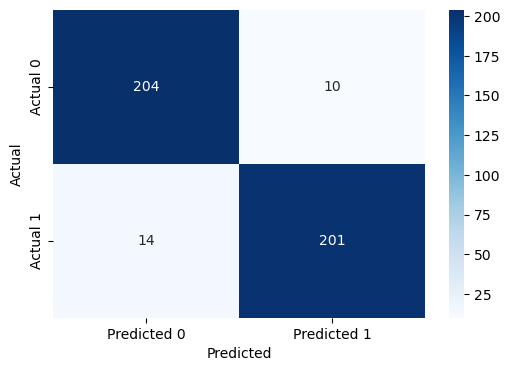

In [61]:
print("Confusion Matrix:")
plt.figure(figsize=(6, 4))
sns.heatmap(tuned_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

---

## 7. Register the Model in SageMaker Model Registry
For MLOps and production pipelines, it's a best practice to register your trained models in the SageMaker Model Registry.

### 7.1. Create a Model Package Group
We first create a model package group to organize different versions of our fraud detection model.

In [62]:
model_package_group_name = "Test-FraudDetectionXGBoostModels"

In [64]:
try:
    sagemaker_session = sagemaker.Session()
    sagemaker_session.sagemaker_client.create_model_package_group(
        ModelPackageGroupName=model_package_group_name,
        ModelPackageGroupDescription="All versions of the fraud detection model"
    )
    print(f"Created new model package group: {model_package_group_name}")
except Exception as e:
    print(f"{e}")

Created new model package group: Test-FraudDetectionXGBoostModels


### 7.2. Define Model Metrics for Registration
We define the performance metrics of our tuned model, which will be stored with the model version in the registry.

In [65]:
model_metrics_report = {
    "binary_classification_metrics": {
        "accuracy": {"value": tuned_accuracy, "standard_deviation": "NaN"},
        "f1_score": {"value": tuned_f1, "standard_deviation": "NaN"},
        "precision": {"value": tuned_precision, "standard_deviation": "NaN"},
        "recall": {"value": tuned_recall, "standard_deviation": "NaN"},
    }
}

In [66]:
metrics_s3_uri = f"s3://{bucket}/{prefix}/reports/{tuner.best_training_job()}-metrics.json"
S3Uploader.upload_string_as_file_body(json.dumps(model_metrics_report), metrics_s3_uri)

's3://test-bucket-second-rerun/fraud-detection/reports/sagemaker-xgboost-250807-1029-017-c1550cb4-metrics.json'

In [67]:
model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=metrics_s3_uri,
        content_type="application/json"
    )
)

### 7.3. Register the Tuned Model
We register the best estimator as a new model package version in our model group.

In [68]:
model_package = best_tuner.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.large"],
    transform_instances=["ml.m5.large"],
    model_package_group_name=model_package_group_name,
    model_metrics=model_metrics,
    approval_status="PendingManualApproval",
    description=f"Best model from tuning job {tuner.latest_tuning_job.name}"
)

In [69]:
model_package_arn = model_package.model_package_arn
print(f"\nSuccessfully registered model version. ARN:\n{model_package_arn}")


Successfully registered model version. ARN:
arn:aws:sagemaker:us-east-1:527054996464:model-package/Test-FraudDetectionXGBoostModels/1


### 7.4. Approve the Model
In a real-world scenario, a model would go through a validation process before being approved. Here, we manually approve the model version we just registered.

You would typically get the ARN from the previous step, but it is hardcoded here for reproducibility.

model_package_arn = "arn:aws:sagemaker:us-east-1:527054996464:model-package/FraudDetectionXGBoostModels/1" 

In [70]:
model_package_update_input = {
    "ModelPackageArn": model_package_arn,
    "ModelApprovalStatus": "Approved",
}

In [71]:
sagemaker_session.sagemaker_client.update_model_package(**model_package_update_input)
print(f"Model package {model_package_arn} approved.")

Model package arn:aws:sagemaker:us-east-1:527054996464:model-package/Test-FraudDetectionXGBoostModels/1 approved.


---

## 8. Cleanup

Finally, to avoid incurring ongoing charges, we delete the SageMaker endpoints we created.

In [72]:
try:
    xgb_predictor.delete_endpoint()
    tuned_xgb_predictor.delete_endpoint()
    print("Both Endpoints have been deleted.")
except Exception as e:
    print(f"Error deleting endpoints: {e}")

INFO:sagemaker:Deleting endpoint configuration with name: fraud-detection-second-rerun-2025-08-07-10-25-07-149
INFO:sagemaker:Deleting endpoint with name: fraud-detection-second-rerun-2025-08-07-10-25-07-149
INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2025-08-07-10-37-39-896
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2025-08-07-10-37-39-896


Both Endpoints have been deleted.
